In [53]:
import pandas as pd
import numpy as np

In [54]:
# pd.set_option('precision',2)

import pandas as pd
import locale

locale.setlocale( locale.LC_ALL, 'English_United States.1252')
locale._override_localeconv = {'n_sign_posn':1}

In [55]:
get_ipython().magic('matplotlib inline')
import matplotlib.pylab as plt
import seaborn as sns
import ggplot as gg
from ggplot import *
import bokeh as bkh

In [56]:
# dataset from https://www.kaggle.com/kaggle/sf-salaries
# sf2014
sf = pd.read_csv('data/sf-salaries/Salaries.csv', usecols=[0,1,2,3,4,5,6,7,9,11,12], dtype={3: object, 4: object, 5: object, 6: object, 12: object}, na_values=['Not Provided', 'Not provided', 'not provided'])

# dataset from http://transparentcalifornia.com/salaries/2015/san-francisco/
# sf2015 = pd.read_csv('data/sf-salaries/san-francisco-2015.csv')

#### na_values=['Not Provided', 'Not provided', 'not provided']

In [57]:
# Combine the 2011-2014 dataset with 2015
# sf = pd.concat([sf2014, sf2015], ignore_index=True)


## Defination of the columns:

### Numeric (needs conversion to numeric):
##### 1. BasePay, OvertimePay, OtherPay, Benefits, TotalPay

### Categorical:
##### 1. Id, EmployeeName, JobTitle, Agency, Status


In [58]:
# sf2014.head()

### MENTOR ### Notice that the *sf 2011-2014" doesnt not have $ in TotalPay

In [59]:
# sf2015.head()

### MENTOR ### Notice that the *sf 2015" doesnt not have $ in TotalPay

## Starting Analysis

* Agency - Represents a region in the larger datasets.
* BasePay - The base rate of pay for a job or activity, excluding additional payments such as overtime or bonuses.
* Benefits - Employees pension plan, free health insurance, and other benefits.
* EmployeeName - Full Name (we can try to use this to analyze gender discrimination)
* Id - Original order of employees from sf2014 dataset, field does not exist in sf 2015
* JobTitle - Employee position held. (There seem to be differences in naming between datasets.)
* Notes - Empty
* OtherPay - Not sure but I would imagine Bonuses or other 'special' benefits. Could include personal flights on public aircrafts.
* OvertimePay - Time paid at California's's 1.5x base pay for over time.
* Status - Classification as FT (Full Time) or PT (Part Time) employee. Only tracked after 2013.
* TotalPay - BasePay + OvertimePay + OtherPay
* Year - Payroll year

In [60]:
sf.isnull().sum()

Id                   0
EmployeeName         6
JobTitle             4
BasePay            609
OvertimePay          4
OtherPay             4
Benefits         36163
TotalPay             0
Year                 0
Agency               0
Status          110535
dtype: int64

In [61]:
sf.Agency.unique()

array(['San Francisco'], dtype=object)

Since the Agency field only contains one unique value, I will remove the field. Notices field is null.

In [62]:
# del sf['Notes']

# Here is another way of dropping a field.

sf.drop(['Agency'], axis=1, inplace=True)

Here I am going to do basic data standardization and cleaning so that it is easier to work with this dataset.

In [63]:
# I am also going to delete any observation where JobTitle is 'Not provided' so that the field can be indexed
sf = sf[sf.JobTitle.notnull()]

# Filling in 'Benefits' if NaN, fill with 0
sf['Benefits'].fillna(0, inplace=True)

# Replace NaN status with "Unknown", since we don't know if its FT or PT work, easier categorization later.
sf['Status'].fillna("Unknown", inplace=True)

# Convert all JobTitle to upper-case character so there is no differentiation in data.
sf['JobTitle'] = sf.JobTitle.str.upper()

# Convert all EmployeeName to upper-case character so there is no differentiation in data. 
# Note: I noticed in pivots duplicate entries if the letter is not standardized.
sf['EmployeeName'] = sf.EmployeeName.str.upper()

In [64]:
# Much cleaner now
sf.isnull().sum()

Id                0
EmployeeName      2
JobTitle          0
BasePay         605
OvertimePay       0
OtherPay          0
Benefits          0
TotalPay          0
Year              0
Status            0
dtype: int64

From reading on the website (where I pulled the dataset) I already saw that there records with zero BasePay, but instead amounts appear in OtherPay and TotalPay, thus 605 null BasePay records does not suprise me.

For Id column I already know that the sf2015 dataset doesnt have an Id column.

In [15]:
sf.BasePay = sf.BasePay.str.lstrip('$')
sf.OtherPay = sf.OtherPay.str.lstrip('$')
sf.OvertimePay = sf.OvertimePay.str.lstrip('$')
sf.TotalPay = sf.TotalPay.str.lstrip('$')
sf.Benefits = sf.Benefits.str.lstrip('$')

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

In [220]:
sf.BasePay = sf.BasePay.str.replace(',','')
sf.OtherPay = sf.OtherPay.str.replace(',','')
sf.OvertimePay = sf.OvertimePay.str.replace(',','')
sf.TotalPay = sf.TotalPay.str.replace(',','')
sf.Benefits = sf.Benefits.str.replace(',','')

In [65]:
sf.BasePay = pd.to_numeric(sf.BasePay)
sf.OvertimePay = pd.to_numeric(sf['OvertimePay'])
sf.OtherPay = pd.to_numeric(sf['OtherPay'])
sf.Benefits = pd.to_numeric(sf['Benefits'])
sf.TotalPay = pd.to_numeric(sf['TotalPay'])



# sf['BasePay'] = pd.to_numeric(sf['BasePay'])
# sf['OvertimePay'] = pd.to_numeric(sf['OvertimePay'])
# sf['OtherPay'] = pd.to_numeric(sf['OtherPay'])
# sf['Benefits'] = pd.to_numeric(sf['Benefits'])
# sf['TotalPay'] = pd.to_numeric(sf['TotalPay'])

In [66]:
sf.dtypes

Id                int64
EmployeeName     object
JobTitle         object
BasePay         float64
OvertimePay     float64
OtherPay        float64
Benefits        float64
TotalPay        float64
Year              int64
Status           object
dtype: object

In [67]:
sf.describe()

,Id,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year
count,148650.00,148045.00,148650.00,148650.00,148650.00,148650.00,148650.00
mean,74325.50,66325.45,5066.06,3648.77,18924.74,74770.33,2012.52
std,42911.70,42764.64,11454.38,8056.60,17165.23,50516.20,1.12
min,1.00,-166.01,-0.01,-7058.59,-33.89,-618.13,2011.00
25%,37163.25,33588.20,0.00,0.00,0.00,36169.96,2012.00
50%,74325.50,65007.45,0.00,811.27,23217.14,71427.24,2013.00
75%,111487.75,94691.05,4658.18,4236.07,33468.98,105842.96,2014.00
max,148654.00,319275.01,245131.88,400184.25,96570.66,567595.43,2014.00


We see that there is some cleaning to do:
1. Remove negative salaries
2. There is some data with null values based on count values
3. TotalPay does not add up

In [68]:
# Min and max in the dataset
print('Min:', sf.Year.min())
print('Max:', sf.Year.max())

Min: 2011
Max: 2014


It looks like we only have Status for year 2014

In [69]:
### MENTOR ### notice that the years prior to 2014 do not show up, they used to show up before I merged datasets

sf_status = sf.groupby(['Year', 'Status']).size()
sf_status.unstack('Year')

Year,2011,2012,2013,2014
Status,,,,
FT,NaN,NaN,NaN,22334.0
PT,NaN,NaN,NaN,15785.0
Unknown,36159.0,36766.0,37606.0,NaN


It looks like we only have Status for year 2014

In [70]:
# Count records per year with a loop
for y in range(min(sf.Year), max(sf.Year)+1):
    print(y, (sf.Year == y).sum())

2011 36159
2012 36766
2013 37606
2014 38119


In [71]:
### MENTOR ### This used to work prior to data merge.

# Average Paid by year
sf[['Year', 'TotalPay']].groupby('Year').mean()

,TotalPay
Year,
2011,71744.10
2012,74113.26
2013,77611.44
2014,75471.84


In [72]:
print(sf[['Year', 'TotalPay']].groupby('Year').sum())
print('(This is in billions)')

      TotalPay
Year          
2011  2.59e+09
2012  2.72e+09
2013  2.92e+09
2014  2.88e+09
(This is in billions)


In [73]:
#Total paid to San Francisco city employees in years 2011 - 2014

print('Total Paid in four years:')

sf['TotalPay'].sum()

Total Paid in four years:


11114610134.380001

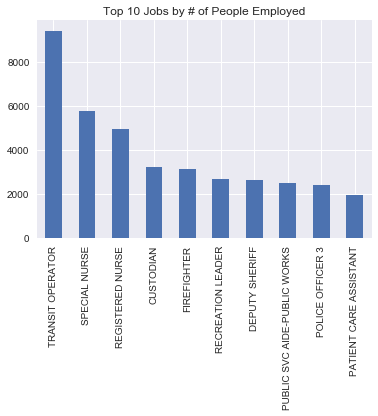

In [74]:
JobTitleCount = sf['JobTitle'].value_counts().head(10)
JobTitleCount.plot(title = "Top 10 Jobs by # of People Employed", kind = 'bar')

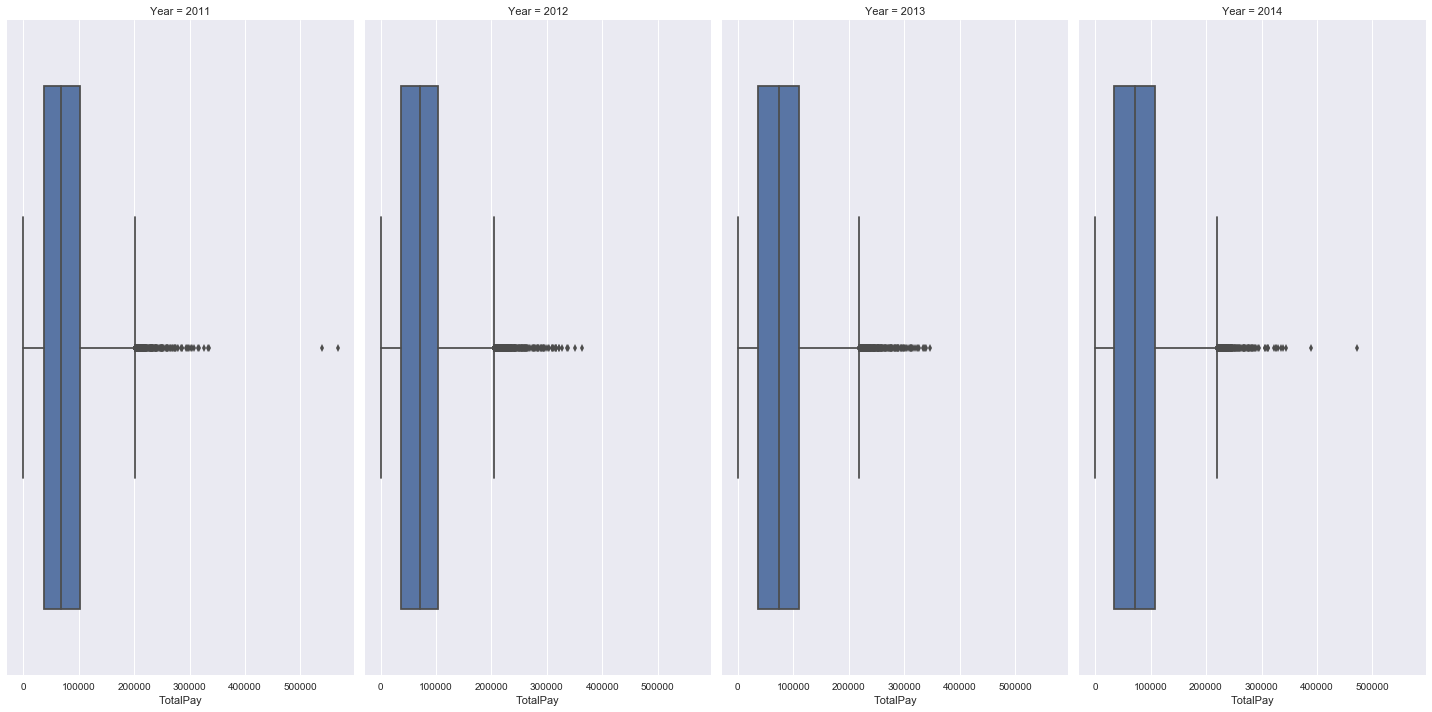

In [75]:
PayByYear = sns.FacetGrid(sf, col="Year", size=10, aspect=.5)
PayByYear = PayByYear.map(sns.boxplot, "TotalPay")

# If this tells us anything, is that there are some extreme outliers.

We can clearly see that there are some extreme outliers in this dataset.

Lets seperate the "High" and "Low" earners to look at them in greater detail.

In [76]:
HighEarners = sf[sf.TotalPay > 300000]
LowEarners = sf[sf.TotalPay < 4000]

In [77]:
pd.pivot_table(HighEarners, index=['JobTitle', 'EmployeeName', 'Year'], values=["TotalPay"])

TotalPay
JobTitle                                       EmployeeName         Year           
ASSISTANT DEPUTY CHIEF 2                       MARK KEARNEY         2012  327689.78
                                               MICHAEL J MORRIS     2013  326376.37
ASSISTANT DEPUTY CHIEF II                      DAVID SULLIVAN       2011  316285.74
ASST CHF OF DEPT (FIRE DEPT)                   DAVID FRANKLIN       2012  315728.77
                                               DAVID L FRANKLIN     2013  333888.32
                                                                    2014  329390.54
                                               THOMAS A SIRAGUSA    2013  324820.63
ASST MED EXAMINER                              AMY P HART           2014  390111.98
                                               ELLEN G MOFFATT      2013  335537.96
                                                                    2014  344187.46
BATTALION CHIEF, (FIRE DEPARTMENT)             ALSON LEE            2011  315981.05
                                               MICHAEL MORRIS       2011  303427.55
BATTALION CHIEF, FIRE SUPPRESS                 BRENDAN A WARD       2013  313142.24
                                               BRYAN W RUBENSTEIN   2013  311000.86
                                                                    2014  306117.53
                                               JOSE L VELO          2014  307099.61
                                               LORRIE A KALOS       2013  301697.70
                                               MARK J JOHNSON       2013  311698.29
                                               MARTY A ROSS         2013  312616.60
                                               SAMSON  LAI          2013  347102.32
                                               SAMSON LAI           2014  335484.96
BATTLION CHIEF, FIRE SUPPRESSI                 BRENDAN WARD         2012  321883.83
                                               MARTY ROSS           2012  310968.31
                                               RUDY CASTELLANOS     2012  316988.26
                                               SAMSON LAI           2012  316214.00
CAPTAIN 3                                      CROCE CASCIATO       2012  311646.16
                                               JOHN EHRLICH         2012  303869.82
                                               JOHN GOLDBERG        2012  350403.41
                                               STEPHEN TACCHINI     2012  308694.09
CAPTAIN III (POLICE DEPARTMENT)                ALBERT PARDINI       2011  335279.91
...                                                                             ...
CAPTAIN, FIRE SUPPRESSION                      MICHAEL ROLOVICH     2012  302002.06
                                               PHILIP STEVENS       2012  308669.82
CHIEF INVESTMENT OFFICER                       WILLIAM J COAKER JR. 2014  339653.70
CHIEF OF DEPARTMENT, (FIRE DEPARTMENT)         JOANNE HAYES-WHITE   2011  302377.73
CHIEF OF POLICE                                GREGORY P SUHR       2013  339282.07
                                                                    2014  326716.76
                                               GREGORY SUHR         2012  321552.11
CHIEF, FIRE DEPARTMENT                         JOANNE HAYES-WHITE   2012  314759.60
                                               JOANNE M HAYES-WHITE 2013  336922.01
                                                                    2014  326233.44
COMMANDER 3                                    RICHARD L CORRIEA    2014  322143.10
DEP DIR FOR INVESTMENTS, RET                   ROBERT L SHAW        2013  315572.01
DEPT HEAD V                                    AMY P HART           2013  303669.15
                                               JOHN L MARTIN        2013  312857.60
                                                                    2014  311298.55
DEPUTY CHIEF 3                             

Above we see the 'JobTitles' and 'EmployeeNames' of the "High Earners", we additionally learn that many of them hold the position for more than one year.

We also see that JobTitles were changed between years, and as a result the same job could appear is distinct, lets create a new field called 'Department' later to hone in and compare departments.

There is also the addition of a middle name initial which is creating duplication in data.

In [78]:
pd.pivot_table(LowEarners, index=['JobTitle', 'EmployeeName', 'Year'], values=["TotalPay"])

TotalPay
JobTitle                       EmployeeName          Year          
ACCOUNT CLERK                  BILING  JIANG         2013   2509.12
                               JOAB MUCHIRI          2014   3468.60
                               KENNETH UCHIDA        2014    237.50
                               LIEN LUM              2011   1630.00
                               MARGARITA E MEN       2013   1871.50
                               NENITA D CELIS        2013   3542.92
                               PAUL M HUNT           2014    949.50
                               PAULET  GAINES        2013      0.00
                               PAULET GAINES         2014      0.00
                               RACHEL LAU            2011   1630.00
                               RICHARD WONG          2012   2848.50
                               TRACY WALKER          2012   2023.00
                               TSE SHIH LENG         2011    614.00
                               ZENON A LOPEZ         2013   1723.00
ACCOUNTANT                     CESAR PALARCA         2011   1148.40
ACCOUNTANT II                  FELINO LOMBOY JR      2012   1667.40
ACCOUNTANT III                 ADAM J VELEZ          2013   2946.98
                               DEE P NGO             2014   3087.00
                               EDITH HORNER          2012   3537.00
                               EVAN J CHAN           2014    510.00
                               VIVIAN LIOU           2012    198.07
                               WILSON H LEE          2013   3491.48
ACCOUNTANT INTERN              JUSTYNA WROBEL        2012   1639.34
                               MANISHA MURJANI       2011   2981.53
ADMIN HEARING EXAMINER         MURIEL L PARENTEAU    2014   3430.91
ADMINISTRATIVE ANALYST         GIZELDA PABROS        2011   2388.24
                               JENNIFER H YEH        2013   2855.60
                               MANISHA  LAL          2013    778.80
                               MARY F KENNY          2013   3780.43
                               MATTHEW M BOYLE       2013   1298.00
...                                                             ...
VENDOR                         DIANA EDWARDS         2011   1233.19
                               MEAGHAN MORRISON      2011   2495.11
                               MICHAEL KELLY         2011   2239.24
                               RUTH MARTIN           2011   3087.95
VICTIM/WITNESS INVESTIGATOR 1  ALICIA N WILEY POWELL 2014    108.71
                               ERIC E RUPP           2013   2472.00
                               LESLIE L LONERGAN     2013   2472.00
                               ROMMEL C CASTELO      2013   2135.00
VOLUNTEER/OUTREACH COORD       ZOE BURTON            2012   2737.20
WAREHOUSE WORKER               THOMAS KYRIMIS        2011   3369.71
WASTEWATER CONTROL INSPECTOR   SONJA RADY            2012   1981.51
                               VICTOR PON            2012      0.00
                                                     2014   1059.28
WATER OPERATIONS ANALYST       STEPHEN APPERSON      2012   3343.45
WATER QUALITY TECH III         GAIL  BARROW          2013   3240.19
WATER QUALITY TECHNICIAN III   SHEK GONG             2011   1060.00
WATER QUALITYTECH I/II         EMILY W WAKEMAN       2013      7.60
                               JOANNE L SHAW         2013      0.00
                                                     2014     54.36
                               LAVERNE  LOCKETT      2013      0.00
WATER SERVICE INSPECTOR        LORENZO ARCE          2011   1810.80
WATERSHED WORKER (SEASONAL)    BRADLEY KILLGORE      2011   1380.00
                               MICHAEL HUMPHREY      2012    293.40
                               VICTOR RIVERS         2011   1380.00
WELDER                         FRANK HODGES          2012    584.41
WELFARE FRAUD INVESTIGATOR     AMANDA GORMLEY        2011    308.70
WIRE ROPE CABLE MAINT MECHANIC RAY  MANAMEA    

In [79]:
# Create a new column called 'Department'
sf['Department'] = ''

When looking at the 'JobTitles' it is clear that employees can be grouped easily into certain departments such as below:

In [80]:
sf.loc[sf.JobTitle.str.contains('POLICE'), 'Department'] = "POLICE"
sf.loc[sf.JobTitle.str.contains("FIRE"), 'Department'] = "FIRE"
sf.loc[sf.JobTitle.str.contains("MEDICAL"), 'Department'] = "MEDICAL"
sf.loc[sf.JobTitle.str.contains("NURSE"), 'Department'] = "MEDICAL"
sf.loc[sf.JobTitle.str.contains("TRANSIT"), 'Department'] = "TRANSIT"

In [84]:
# Applying $ (currency) for formatting and attractive presentation

ByDepartment = pd.pivot_table(sf, index=['Department'], values=["TotalPay"], aggfunc=[np.sum, np.mean, len], fill_value=0)
ByDepartment.ix[:,0] = ['${:,.2f} MM'.format(x) for x in ByDepartment.ix[:,0]/1000000]
ByDepartment.ix[:,1] = ['${:,.2f}'.format(x) for x in ByDepartment.ix[:,1]]
ByDepartment

,sum,mean,len
,TotalPay,TotalPay,TotalPay
Department,,,
,"$7,271.11 MM","$67,718.00",107373
FIRE,$891.76 MM,"$151,686.00",5879
MEDICAL,"$1,093.42 MM","$72,585.00",15064
POLICE,$992.40 MM,"$121,009.00",8201
TRANSIT,$865.92 MM,"$71,369.00",12133


In the above table we can see the total of pay, average pay and count per Department

In [159]:
# https://www.kaggle.com/dmitriy19/d/kaggle/sf-salaries/explore-sf-salary-data-quick-eda

In [160]:
# Are there any duplicate names in the dataset?

In [161]:
# Which employee has been employed three years?

In [162]:
# What is the correlation between titles and salaries?

## THIS IS WHERE I STOPPED

In [85]:
## http://seaborn.pydata.org/generated/seaborn.regplot.html

Police2014 = sf[(sf.Department == 'POLICE') & (sf.Year == 2015) & (sf.Status != 'PT')]
Police2014_Pivot = pd.pivot_table(Police2014, index=['JobTitle'], values=["TotalPay"], aggfunc=[np.sum])
Police2014_Pivot
# sns.regplot('JobTitle', 'TotalPay', data=Police2014)

,sum
,TotalPay
JobTitle,


In [163]:
# How have salaries changed between the years?

In [164]:
# Can you make a bar plot or a histogram?

In [165]:
# Can you compare two related quantities?

In [100]:
sf_dept = sf

In [108]:
sf_dept = sf[sf.Department.isnull()]
sf_dept

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year,Status,Department


In [101]:
pd.pivot_table(sf, index=['Deparment'], values=['Benfits'], aggfunc=[np.sum])

#pd.pivot_table(Police2014, index=['JobTitle'], values=["TotalPay"], aggfunc=[np.sum])

KeyError: 'Deparment'

In [166]:
# Can you make a scatterplot?

In [167]:
# Can you make a time-series plot?

In [168]:
# How have salaries changed over time between different groups of people?

In [169]:
# How are base pay, overtime pay and benefits allocated between different groups?

In [170]:
# Can we split the dataset between males and females?

In [171]:
# Is there any evidene of pay discrimination based on gender in this dataset?

In [172]:
# How is budget allocated based on different groups and responsibilities?

In [274]:
# Any 80/20 principals I can identify?

In [277]:
# Integrate ideas from here:
# https://public.tableau.com/profile/lawrence.chernin#!/vizhome/SanFranciscoSalaries/CountsbyTitle

## Probably will not be used:

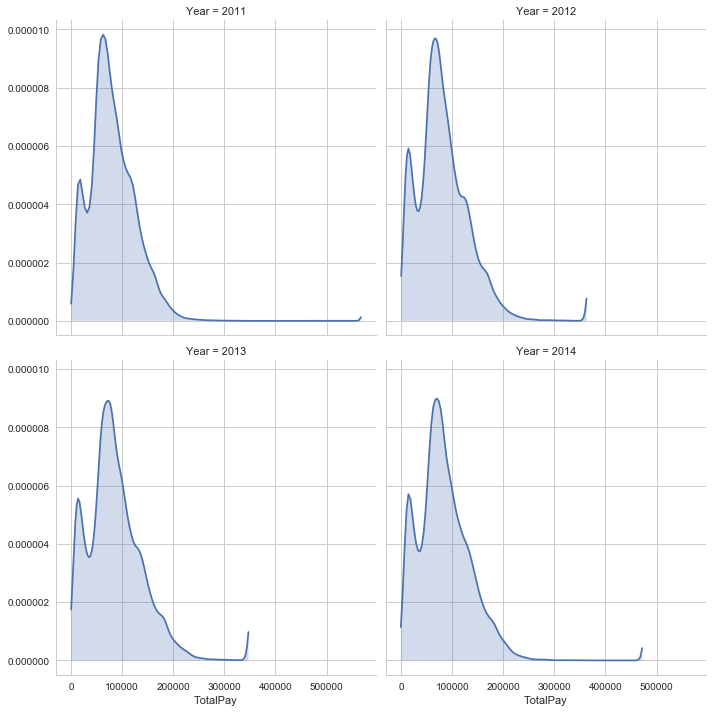

In [514]:
# Probably should delete this
TotalPay = sns.FacetGrid(sf, col="Year", col_wrap=2, size=5, dropna=True)
sns.set_style("whitegrid")
TotalPay.map(sns.kdeplot, 'TotalPay', shade=True, cut=0);